## We attempt to create a predictor that can predict the outcome of a match given previous wins (2017 IPL Matches).<br>
### Using dataset: matches.csv (636 rows)
<p>
    We create a basic predictor that uses a neural network to predict the match outcome. The model will exported to Django where a web interface will interact with the model.<br>
    </p>

In [2]:
import pandas as pd
import numpy as np
import keras
from keras.utils import to_categorical, plot_model
from keras.preprocessing.text import Tokenizer
from keras import Sequential
from keras import losses
from keras.layers import Dense
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, log_loss, recall_score
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [24]:
# Loading dataset
data = pd.read_csv("matches.csv")

In [26]:
data.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [4]:
# Removing unwanted columns
data.drop(columns=['venue', 'player_of_match', 'dl_applied','umpire1','umpire2','umpire3','date','city','season','id'], inplace=True)

In [5]:
# Label encoding toss_decision
data.toss_decision = data.toss_decision.map({'bat':1, 'field':0})

In [6]:
# Encoding result
data.result = data.result.map({'normal':1, 'tie':2, 'no result':0})

In [7]:
r = len(data.team2.unique())
teams = data.team1.unique()
mapping = {}

In [8]:
for i in range(14): # There are 14 teams.
    mapping[teams[i]] = i

In [9]:
data.toss_winner = data.toss_winner.map(mapping)

In [10]:
# Encoding team data in numeric form
data.team1 = data.team1.map(mapping)
data.team2 = data.team2.map(mapping)
mapping # A value is repeated

{'Chennai Super Kings': 8,
 'Deccan Chargers': 10,
 'Delhi Daredevils': 6,
 'Gujarat Lions': 2,
 'Kings XI Punjab': 7,
 'Kochi Tuskers Kerala': 11,
 'Kolkata Knight Riders': 5,
 'Mumbai Indians': 1,
 'Pune Warriors': 12,
 'Rajasthan Royals': 9,
 'Rising Pune Supergiant': 3,
 'Rising Pune Supergiants': 13,
 'Royal Challengers Bangalore': 4,
 'Sunrisers Hyderabad': 0}

In [11]:
data.winner = data.winner.map(mapping)

In [12]:
# Removing NA Fields
data.dropna(axis=0,inplace=True)

In [13]:
data.winner = data.winner.astype(int)

In [14]:
data.head()

,team1,team2,toss_winner,toss_decision,result,winner,win_by_runs,win_by_wickets
0,0,4,4,0,1,0,35,0
1,1,3,3,0,1,3,0,7
2,2,5,5,0,1,5,0,10
3,3,7,7,0,1,7,0,6
4,4,6,4,1,1,4,15,0


In [22]:
len(data)

633

<p>
    While we think that <b>win_by_runs</b> and <b> win_by_wickets </b> are important metrics for the dataset, we are dropping it for user's simplicity.</p>

In [15]:
data.drop(columns=["win_by_runs", "win_by_wickets"], axis=1, inplace=True)

In [16]:
data.head()

,team1,team2,toss_winner,toss_decision,result,winner
0,0,4,4,0,1,0
1,1,3,3,0,1,3
2,2,5,5,0,1,5
3,3,7,7,0,1,7
4,4,6,4,1,1,4


In [17]:
data.drop(columns=["toss_decision", "result"], inplace=True)

In [18]:
data.head()

,team1,team2,toss_winner,winner
0,0,4,4,0
1,1,3,3,3
2,2,5,5,5
3,3,7,7,7
4,4,6,4,4


In [19]:
labels = data.winner.values
features = data.drop(columns=["winner"], axis=1).values

labels_copy = data.winner.values
features_copy = data.drop(columns=["winner"], axis=1).values


In [20]:
features.shape

(633, 3)

In [21]:
# We have three input dim
labels.shape

(633,)

In [114]:
# As there is no activaton function that can predict 'winner', we are one hot encoding it.
labels = to_categorical(labels)

In [35]:
labels

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.]])

In [36]:
labels.shape

(633, 14)

In [37]:
# Now we will use a softmax which will provide probs for 14 different classes aka teams.

In [118]:
features_train, features_test, labels_train,labels_test = train_test_split(features, labels, shuffle=True, random_state=42)
features_copy_train, features_copy_test, labels_copy_train,labels_copy_test = train_test_split(features, labels, shuffle=True, random_state=42)

In [40]:
len(features_train)

474

In [41]:
len(features_test)

159

In [89]:
# Creating model
model = Sequential()
model.add(Dense(100, activation="relu", input_dim=features.shape[1]))
model.add(Dense(75, activation="relu"))
model.add(Dense(75, activation="relu"))
model.add(Dense(labels.shape[1], activation="softmax"))
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=losses.categorical_crossentropy, metrics=["accuracy"])

In [90]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 100)               400       
_________________________________________________________________
dense_13 (Dense)             (None, 75)                7575      
_________________________________________________________________
dense_14 (Dense)             (None, 75)                5700      
_________________________________________________________________
dense_15 (Dense)             (None, 14)                1064      
Total params: 14,739
Trainable params: 14,739
Non-trainable params: 0
_________________________________________________________________


In [91]:
# Let us train the model
history = model.fit(features_train, labels_train, epochs=1000, validation_data=(features_test, labels_test), batch_size=25)

Train on 474 samples, validate on 159 samples
Epoch 1/1000
474/474 [==============================] - 0s 828us/step - loss: 2.5497 - acc: 0.1181 - val_loss: 2.3543 - val_acc: 0.2013
Epoch 2/1000
474/474 [==============================] - 0s 116us/step - loss: 2.3696 - acc: 0.2004 - val_loss: 2.2587 - val_acc: 0.2013
Epoch 3/1000
474/474 [==============================] - 0s 128us/step - loss: 2.2838 - acc: 0.2321 - val_loss: 2.1899 - val_acc: 0.2642
Epoch 4/1000
474/474 [==============================] - 0s 117us/step - loss: 2.2168 - acc: 0.2426 - val_loss: 2.1594 - val_acc: 0.2642
Epoch 5/1000
474/474 [==============================] - 0s 125us/step - loss: 2.1714 - acc: 0.2363 - val_loss: 2.1430 - val_acc: 0.2956
Epoch 6/1000
474/474 [==============================] - 0s 126us/step - loss: 2.1319 - acc: 0.2827 - val_loss: 2.1234 - val_acc: 0.3019
Epoch 7/1000
474/474 [==============================] - 0s 123us/step - loss: 2.0975 - acc: 0.2975 - val_loss: 2.1402 - val_acc: 0.3145
Ep

Epoch 120/1000
474/474 [==============================] - 0s 149us/step - loss: 1.1847 - acc: 0.5190 - val_loss: 2.0346 - val_acc: 0.4340
Epoch 121/1000
474/474 [==============================] - 0s 153us/step - loss: 1.1959 - acc: 0.4979 - val_loss: 2.0143 - val_acc: 0.5157
Epoch 122/1000
474/474 [==============================] - 0s 146us/step - loss: 1.1922 - acc: 0.5105 - val_loss: 1.9817 - val_acc: 0.4906
Epoch 123/1000
474/474 [==============================] - 0s 152us/step - loss: 1.1412 - acc: 0.5506 - val_loss: 2.0556 - val_acc: 0.4591
Epoch 124/1000
474/474 [==============================] - 0s 148us/step - loss: 1.1610 - acc: 0.5338 - val_loss: 2.0249 - val_acc: 0.4969
Epoch 125/1000
474/474 [==============================] - 0s 140us/step - loss: 1.1610 - acc: 0.5042 - val_loss: 2.0417 - val_acc: 0.5031
Epoch 126/1000
474/474 [==============================] - 0s 137us/step - loss: 1.1516 - acc: 0.5232 - val_loss: 2.0439 - val_acc: 0.4277
Epoch 127/1000
474/474 [==========

474/474 [==============================] - 0s 115us/step - loss: 0.8872 - acc: 0.5949 - val_loss: 1.9037 - val_acc: 0.5472
Epoch 239/1000
474/474 [==============================] - 0s 113us/step - loss: 0.8970 - acc: 0.5928 - val_loss: 1.9397 - val_acc: 0.5094
Epoch 240/1000
474/474 [==============================] - 0s 109us/step - loss: 0.8844 - acc: 0.6224 - val_loss: 1.9230 - val_acc: 0.4969
Epoch 241/1000
474/474 [==============================] - 0s 114us/step - loss: 0.9044 - acc: 0.6034 - val_loss: 1.8915 - val_acc: 0.5094
Epoch 242/1000
474/474 [==============================] - 0s 113us/step - loss: 0.8889 - acc: 0.6203 - val_loss: 1.9896 - val_acc: 0.5157
Epoch 243/1000
474/474 [==============================] - 0s 110us/step - loss: 0.8797 - acc: 0.6013 - val_loss: 1.9756 - val_acc: 0.5220
Epoch 244/1000
474/474 [==============================] - 0s 116us/step - loss: 0.8736 - acc: 0.5802 - val_loss: 1.9147 - val_acc: 0.5220
Epoch 245/1000
474/474 [=========================

474/474 [==============================] - 0s 106us/step - loss: 0.7461 - acc: 0.6540 - val_loss: 1.9691 - val_acc: 0.5346
Epoch 357/1000
474/474 [==============================] - 0s 111us/step - loss: 0.7627 - acc: 0.6456 - val_loss: 1.9804 - val_acc: 0.5849
Epoch 358/1000
474/474 [==============================] - 0s 110us/step - loss: 0.7895 - acc: 0.6160 - val_loss: 1.9384 - val_acc: 0.5157
Epoch 359/1000
474/474 [==============================] - 0s 103us/step - loss: 0.7732 - acc: 0.6498 - val_loss: 1.9158 - val_acc: 0.5786
Epoch 360/1000
474/474 [==============================] - 0s 109us/step - loss: 0.7682 - acc: 0.6266 - val_loss: 2.0111 - val_acc: 0.5094
Epoch 361/1000
474/474 [==============================] - 0s 107us/step - loss: 0.7700 - acc: 0.6203 - val_loss: 1.9627 - val_acc: 0.5535
Epoch 362/1000
474/474 [==============================] - 0s 105us/step - loss: 0.7476 - acc: 0.6329 - val_loss: 1.9316 - val_acc: 0.5535
Epoch 363/1000
474/474 [=========================

474/474 [==============================] - 0s 103us/step - loss: 0.7069 - acc: 0.6624 - val_loss: 2.0126 - val_acc: 0.4906
Epoch 475/1000
474/474 [==============================] - 0s 113us/step - loss: 0.6686 - acc: 0.6646 - val_loss: 1.9868 - val_acc: 0.5912
Epoch 476/1000
474/474 [==============================] - 0s 104us/step - loss: 0.6831 - acc: 0.6582 - val_loss: 2.0045 - val_acc: 0.5283
Epoch 477/1000
474/474 [==============================] - 0s 110us/step - loss: 0.6745 - acc: 0.6498 - val_loss: 2.0327 - val_acc: 0.5597
Epoch 478/1000
474/474 [==============================] - 0s 105us/step - loss: 0.6916 - acc: 0.6392 - val_loss: 2.0028 - val_acc: 0.5220
Epoch 479/1000
474/474 [==============================] - 0s 111us/step - loss: 0.7050 - acc: 0.6435 - val_loss: 1.9761 - val_acc: 0.5472
Epoch 480/1000
474/474 [==============================] - 0s 102us/step - loss: 0.6976 - acc: 0.6350 - val_loss: 2.0018 - val_acc: 0.5472
Epoch 481/1000
474/474 [=========================

474/474 [==============================] - 0s 113us/step - loss: 0.6367 - acc: 0.6582 - val_loss: 2.0244 - val_acc: 0.5409
Epoch 593/1000
474/474 [==============================] - 0s 103us/step - loss: 0.6387 - acc: 0.6835 - val_loss: 2.0501 - val_acc: 0.5157
Epoch 594/1000
474/474 [==============================] - 0s 103us/step - loss: 0.6715 - acc: 0.6751 - val_loss: 2.0368 - val_acc: 0.5346
Epoch 595/1000
474/474 [==============================] - 0s 110us/step - loss: 0.6556 - acc: 0.6730 - val_loss: 2.0508 - val_acc: 0.4906
Epoch 596/1000
474/474 [==============================] - 0s 107us/step - loss: 0.6672 - acc: 0.6730 - val_loss: 1.9799 - val_acc: 0.5346
Epoch 597/1000
474/474 [==============================] - 0s 111us/step - loss: 0.6431 - acc: 0.6814 - val_loss: 2.0447 - val_acc: 0.5094
Epoch 598/1000
474/474 [==============================] - 0s 122us/step - loss: 0.6383 - acc: 0.6857 - val_loss: 1.9656 - val_acc: 0.6101
Epoch 599/1000
474/474 [=========================

474/474 [==============================] - 0s 124us/step - loss: 0.6264 - acc: 0.6751 - val_loss: 2.0259 - val_acc: 0.5283
Epoch 711/1000
474/474 [==============================] - 0s 135us/step - loss: 0.6198 - acc: 0.6709 - val_loss: 2.0199 - val_acc: 0.5472
Epoch 712/1000
474/474 [==============================] - 0s 120us/step - loss: 0.6160 - acc: 0.6730 - val_loss: 2.0656 - val_acc: 0.5031
Epoch 713/1000
474/474 [==============================] - 0s 105us/step - loss: 0.6252 - acc: 0.6772 - val_loss: 2.0507 - val_acc: 0.5094
Epoch 714/1000
474/474 [==============================] - 0s 107us/step - loss: 0.6466 - acc: 0.6308 - val_loss: 2.1284 - val_acc: 0.4465
Epoch 715/1000
474/474 [==============================] - 0s 105us/step - loss: 0.6111 - acc: 0.6814 - val_loss: 2.0565 - val_acc: 0.5346
Epoch 716/1000
474/474 [==============================] - 0s 104us/step - loss: 0.6271 - acc: 0.6730 - val_loss: 2.0320 - val_acc: 0.5535
Epoch 717/1000
474/474 [=========================

474/474 [==============================] - 0s 103us/step - loss: 0.5966 - acc: 0.6793 - val_loss: 2.1063 - val_acc: 0.5094
Epoch 829/1000
474/474 [==============================] - 0s 106us/step - loss: 0.6095 - acc: 0.7046 - val_loss: 2.1261 - val_acc: 0.5157
Epoch 830/1000
474/474 [==============================] - 0s 110us/step - loss: 0.6094 - acc: 0.6793 - val_loss: 2.0857 - val_acc: 0.5094
Epoch 831/1000
474/474 [==============================] - 0s 113us/step - loss: 0.5921 - acc: 0.6857 - val_loss: 2.1013 - val_acc: 0.4969
Epoch 832/1000
474/474 [==============================] - 0s 101us/step - loss: 0.6217 - acc: 0.6709 - val_loss: 2.0529 - val_acc: 0.5094
Epoch 833/1000
474/474 [==============================] - 0s 111us/step - loss: 0.5928 - acc: 0.6540 - val_loss: 2.0863 - val_acc: 0.5409
Epoch 834/1000
474/474 [==============================] - 0s 118us/step - loss: 0.5911 - acc: 0.6814 - val_loss: 2.1029 - val_acc: 0.4654
Epoch 835/1000
474/474 [=========================

474/474 [==============================] - 0s 104us/step - loss: 0.6139 - acc: 0.6456 - val_loss: 2.0241 - val_acc: 0.5472
Epoch 947/1000
474/474 [==============================] - 0s 103us/step - loss: 0.6382 - acc: 0.6582 - val_loss: 2.0818 - val_acc: 0.4906
Epoch 948/1000
474/474 [==============================] - 0s 103us/step - loss: 0.5897 - acc: 0.6709 - val_loss: 2.1114 - val_acc: 0.4843
Epoch 949/1000
474/474 [==============================] - 0s 117us/step - loss: 0.5866 - acc: 0.6983 - val_loss: 2.0957 - val_acc: 0.5283
Epoch 950/1000
474/474 [==============================] - 0s 129us/step - loss: 0.5857 - acc: 0.6835 - val_loss: 2.1163 - val_acc: 0.5472
Epoch 951/1000
474/474 [==============================] - 0s 121us/step - loss: 0.5770 - acc: 0.6730 - val_loss: 2.1076 - val_acc: 0.5157
Epoch 952/1000
474/474 [==============================] - 0s 103us/step - loss: 0.6006 - acc: 0.6793 - val_loss: 2.1259 - val_acc: 0.5660
Epoch 953/1000
474/474 [=========================

In [123]:
pred = model.predict(features_test)
e = model.evaluate(features_test, labels_test)
print ("Loss: ", e[0])
print ("Accuracy on the test set: ", e[1])

159/159 [==============================] - 0s 49us/step
Loss:  2.1267692293
Accuracy on the test set:  0.515723267066


In [94]:
pred

array([[  4.88489327e-12,   3.14878129e-18,   2.58467764e-26, ...,
          1.78388362e-08,   2.34954502e-03,   1.41198167e-26],
       [  3.77800546e-08,   4.37068408e-08,   1.09651204e-07, ...,
          1.74638992e-21,   1.98601648e-17,   0.00000000e+00],
       [  2.73054183e-11,   2.45438420e-10,   8.80327922e-10, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  1.52845114e-08,   3.42711743e-08,   4.38011397e-04, ...,
          1.02629394e-09,   7.27901443e-06,   1.32194672e-31],
       [  3.68139154e-04,   5.05491674e-01,   3.75506011e-06, ...,
          1.99810401e-33,   0.00000000e+00,   0.00000000e+00],
       [  1.26554328e-03,   1.78656580e-06,   0.00000000e+00, ...,
          6.77440169e-31,   3.77130776e-34,   4.37663541e-24]], dtype=float32)

In [124]:
# Now we we will use np.argmax to get the max probability and the index
pred = np.argmax(pred, axis=1)

In [96]:
pred

array([ 6,  8,  4,  6,  8,  1,  8,  5,  9,  7,  8,  0,  3,  7,  0,  7,  2,
        1, 10,  1,  1, 10,  1,  3,  8,  4, 10, 10,  4, 11,  0,  1, 10,  4,
        6, 11,  4,  4,  4,  8,  1,  4,  8,  5,  4,  6, 10,  4,  8, 10,  8,
        7,  5,  6,  2, 12, 10,  1,  5,  5,  0,  1,  4,  4,  7,  9,  0,  0,
        0,  1,  9,  4,  8,  6,  8,  1,  5,  8,  6, 10, 10,  8,  4,  8,  4,
        5,  4,  8,  5,  6,  1, 12,  4,  5, 10,  4,  8,  9,  1, 11,  0, 12,
        1,  9, 12,  1,  4,  8,  1,  7, 10,  9,  6,  8,  8,  4, 12,  1,  4,
        8,  6,  5,  4,  8,  9,  0,  8,  1,  9,  9,  0,  5,  1, 10,  1,  9,
        6,  8,  1,  1,  8,  7,  4,  0,  8,  0,  1,  1,  0,  4,  6,  5,  4,
        4,  4,  4,  4,  1,  9])

In [97]:
decoded_labels_test = np.argmax(labels_test, axis=1)

In [98]:
decoded_labels_test

array([ 6,  8,  4,  6,  4,  8,  5,  9,  7,  7,  8,  0,  3,  8,  4,  7,  5,
        1,  8,  7,  1, 10,  7,  4,  5,  4, 10,  6,  4,  8,  7,  7, 10,  4,
        9,  5,  8,  4,  4, 12,  1,  3,  8,  0,  4,  5, 10,  4,  6,  4,  8,
        7,  5,  6,  7,  2,  6,  1,  5,  5,  0,  1,  6,  7,  7,  8,  5,  0,
        0,  5,  9,  3,  9,  7,  4,  7,  5,  8,  6,  1,  5,  8,  4,  8, 10,
        5,  2,  8,  5,  8,  1,  1,  2,  5,  1,  4,  8,  9,  1, 11,  8,  6,
        1,  1, 12,  1,  1,  9,  1,  8,  5,  1,  7,  8,  7,  4,  5,  8,  7,
       10,  5,  5,  8,  8,  9,  0,  9,  1,  9,  9,  7,  9,  1,  9,  5,  9,
        6,  8,  9,  1,  8, 10,  9,  3,  8,  0,  8,  1,  5,  4,  1,  5,  4,
        7,  4,  4,  4,  1,  0])

In [112]:
# Checking accuracy (Using a 3 hidden layer neural network)
print ("The accuracy of the mode is : ", accuracy_score(decoded_labels_test, pred))

The accuracy of the mode is :  0.51572327044


In [100]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [104]:
clf = SVC()
clf.fit(features_copy_train, labels_copy_train)
clf.score(features_copy_test, labels_copy_test)

0.50314465408805031

In [106]:
labels_copy_train

array([ 4,  6,  6,  8,  4,  1,  8,  6,  5,  1,  8,  1,  8,  0,  5, 10,  8,
        6,  2, 10,  4,  2,  1, 10,  8,  6,  6,  9,  7,  7, 10,  1,  1,  6,
        9,  6,  1,  1,  8,  1,  0, 13,  9,  7,  4,  6,  1,  2,  9,  9,  1,
        1,  4,  4,  0,  7,  7,  9, 13,  7,  1,  9,  1,  6,  6, 12,  5,  4,
        0,  0,  7,  0,  1,  6,  4,  5,  0,  9,  2,  9,  1,  0,  7,  9, 12,
        8,  8,  7,  9,  9,  0,  9,  4,  0,  9,  7,  6,  6,  8,  5, 10,  7,
        0,  2,  7,  1,  7,  1,  4,  4,  7,  1,  7,  8,  4,  1,  4,  5,  1,
        1, 10,  7,  9,  8,  4, 10,  1,  1,  4,  5,  5, 12,  7,  6, 13,  1,
        9,  4,  4,  5,  4,  8,  7,  2,  4,  0,  2,  5,  0,  5,  3,  6,  4,
        1,  7,  7,  4,  6,  4,  8,  8, 10,  1,  5,  1,  8,  6,  5,  3,  6,
        1,  0,  1,  5,  8,  9,  1,  9,  2,  4,  9,  7,  8,  8, 10,  9,  1,
       13,  1,  1,  9,  5,  0,  8,  6,  0,  1,  6,  0,  6,  9,  7, 13,  7,
        1,  7,  4,  5,  6,  8,  1,  9,  1,  1,  1,  5,  5,  5,  5,  4,  9,
        4,  6,  5,  7,  9

In [126]:
clf2 = RandomForestClassifier(n_estimators=100)
clf2.fit(features_copy_train, labels_copy_train)
clf2.score(features_copy_test, labels_copy_test)

0.43396226415094341

## On average, we are getting an accuracy of 50-ish %.

In [127]:
# Saving keras model
model.save("match-predictor.h5")
plot_model(model, to_file="predictor-arch.png",show_layer_names=False, show_shapes=True)

In [133]:
features_train.shape

(474, 3)

In [136]:
from keras.models import load_model

In [137]:
model.save("test.json")

In [138]:
x = load_model("test.json")

In [1]:
x.predict(np.array([ [3,0, 1]])) # Match against  Pune and Sunrisers

NameError: name 'x' is not defined

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA()
import matplotlib.pyplot as plt

In [30]:
pca.fit(StandardScaler().fit_transform(features))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

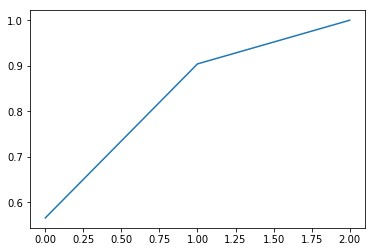

In [31]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))